# TP3: Mean Shift

## Student: Megi Dervishi

Read, understand, and complete and run the following notebook. You must return the completed notebook, including your answers and illustrations (you may need to add cells to write your code or comments). 

Return your work on the moodle (or by e-mail) using a single file (ipynb or zip).

## Imports

In [1]:
# See TP1 for information about those imports
import numpy as np
import matplotlib.pyplot as plt 
import scipy.ndimage as ndimage
plt.rcParams['image.cmap'] = 'gray' 

# For colorspace conversions in the last section
from skimage.color import rgb2lab,lab2rgb

## 1. Mean shift

In this section, we will implement Mean Shift and test is on simple synthetic data (*i.e.* points you will sample from a probability distribution with known density - see below).

**1.a)** Generate a random vector of 100 2D points `data1` with 50 points sampled from a Gaussian distribution of variance (1, 1) centered in (0, 0) and 50 points sampled from a Gaussian distribution of variance (1, 1) centered in (2, 1).<br/>
Plot your points using the `plt.scatter` function.

**b)** Repeat to create a vector `data2` with the center of the second Gaussian in (3,3). 

These `data` vectors will be the synthetic data you will try to cluster, and for which the algorithm should manage to separate the point coming from each of the two Gaussians. 
In each of the following experiment, **test on both**.

**c)** Which will be the easiest `data` vector to cluster?

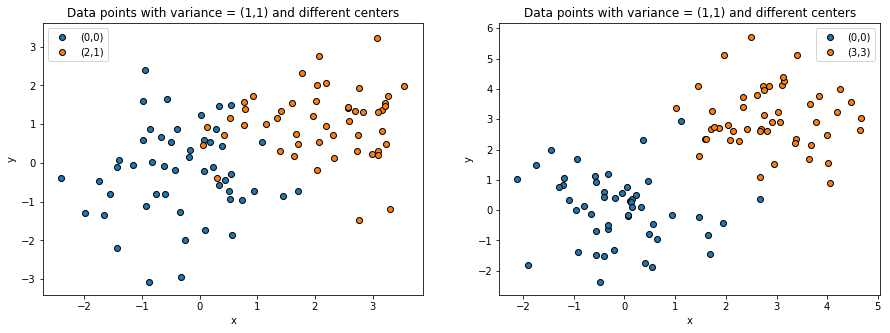

In [2]:
# Q.1

#generate the data points
pts0 = np.random.normal(np.array([0,0]), np.array([1,1]), (50,2))
pts1 = np.random.normal(np.array([2,1]), np.array([1,1]), (50,2))
data1 = np.concatenate([pts0, pts1])

pts00 = np.random.normal(np.array([0,0]), np.array([1,1]), (50,2))
pts3 = np.random.normal(np.array([3,3]), np.array([1,1]), (50,2))
data2 = np.concatenate([pts00, pts1])

#plot the data
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(pts0[:,0], pts0[:, 1], edgecolors = 'black', label='(0,0)')
plt.scatter(pts1[:,0], pts1[:, 1], edgecolors= 'black', label='(2,1)')
plt.title("Data points with variance = (1,1) and different centers")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(pts00[:,0], pts00[:, 1], edgecolors = 'black', label='(0,0)')
plt.scatter(pts3[:,0], pts3[:, 1], edgecolors= 'black', label='(3,3)')
plt.title("Data points with variance = (1,1) and different centers")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

**Answer 1.c.**
The easiest `data` vector to cluster for the algorithm would be `data2`. As we can see from the plots the points are more easily distinguishable in `data2` than `data1`.  

In the end of this homework, we will segment images using a different bandwidth for space and color. For this reason, we will use **a *d*-dimensional vector `sigma`** as a parameter for all our mean-shift functions. It defines a scale for each dimension (*i.e.* we want to do an anisotropic clustering). 

**2.** What would be a meaningful parameter `sigma` for each of the synthetic data sets (`data1` and `data2`)? Explain quickly why.

**Answer 2** 
If we choose a very big value for $\sigma$ then the algorithm may not be able to split the data points into different clusters and if we choose too small value then there might be overfitting. Since we know that the data points are generated by a Gaussian of variance $(1,1)$ we can choose a slightly lower one (from Q.5 we can see that a good one is [0.6,0.6])

In [3]:
#Q.2
sigma1 = np.array([0.6,0.6])
sigma2 = np.array([0.6,0.6])

The formula in the lectures are mostly derived for the isotropic case. The simple way to deal with the anisotropy is to divide each coordinate $x_i$ by its corresponding $\sigma_i$ rather than by a global $\sigma$ -- *e.g.* distance between points $\mathbf x$ and $\mathbf y$ normalized by $\sigma$ becomes $\sqrt{\sum_i^d{\left(\frac{\mathbf x_i- \mathbf y_i}{\sigma_i}\right)^2}}$

**Optional math question.** *(Answer it **only** when you have finished the TP)* What changes exactly in the anisotropic case? Why is doing that valid, what consequences does it have on gradients?


**3.a)** Implement the function `MS_step` which takes as input a vector of all the data points `data`, a starting point `x` and the standard deviations `sigma` and returns the updated position of the point `x` after one step of the mean-shift algorithm. <br/>
**b)** Test it on your synthetic data and visualize the result.

**Comment 3.a.**
The pdf of a multivariate normal distribution is:
\begin{align}
{\displaystyle (2\pi )^{-{\frac {k}{2}}}\det({\boldsymbol {\Sigma }})^{-{\frac {1}{2}}}\,e^{-{\frac {1}{2}}(\mathbf {x} -{\boldsymbol {X_i }})^{\!{\mathsf {T}}}{\boldsymbol {\Sigma }}^{-1}(\mathbf {x} -{\boldsymbol {X_i }})}}
\end{align}
where in our case $\Sigma = \sigma^2 \cdot \text{Id}$. 

In [4]:
#Q.3.a

def MS_step(data, x, sigma):
  #x = np.repeat(x, 100, axis=1)
  Sigma = np.diag(sigma)**2
  mult = np.einsum('ji,ji->i', x-data, np.linalg.inv(Sigma) @ (x-data))
  exponent = -1/2* mult
  k = data.shape[0]
  pdf = (2*np.pi)**(-k/2)* np.linalg.det(Sigma)**(-1/2) * np.exp(exponent) 
  return (data @ pdf) / np.sum(pdf)

#applies the function f pointwise for data1, data2
def apply_pointwise(data, sigma, f):
  step =  []
  for i in range(len(data)):
    x = data[i].reshape(len(data[i]),1)
    step.append(f(data.T, x, sigma))
  return np.array(step)

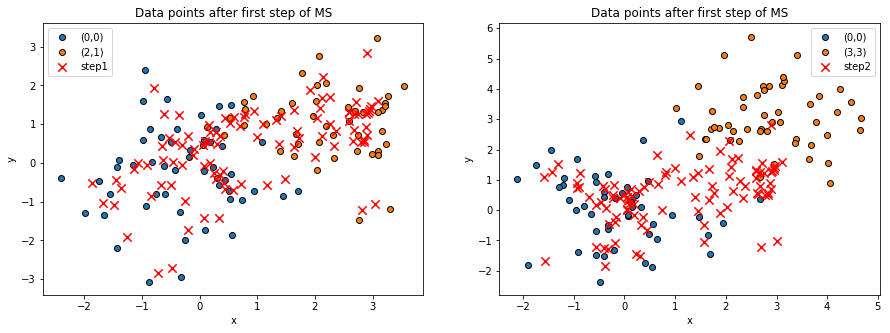

In [5]:
#Q.3.b
step1 = apply_pointwise(data1, sigma1, MS_step)
step2 = apply_pointwise(data2, sigma2, MS_step)
#visualise
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(pts0[:,0], pts0[:, 1], edgecolors = 'black', label='(0,0)')
plt.scatter(pts1[:,0], pts1[:, 1], edgecolors= 'black', label='(2,1)')
plt.scatter(step1[:, 0], step1[:, 1], marker='x',s = 70, color='red', label = 'step1')
plt.title("Data points after first step of MS")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(pts00[:,0], pts00[:, 1], edgecolors = 'black', label='(0,0)')
plt.scatter(pts3[:,0], pts3[:, 1], edgecolors= 'black', label='(3,3)')
plt.scatter(step2[:, 0], step2[:, 1], marker='x',s = 70, color='red', label = 'step2')
plt.title("Data points after first step of MS")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

**4.a)** Implement the function `MS_point` which iterates `MS_step` until convergence (*e.g.* the estimate changes by less than 0.01).<br/>
**b)** Test it on your synthetic data and visualize the results.

In [6]:
#Q.4.a
def MS_point(data, x, sigma):
    epsilon = 0.01
    xprev = np.inf*x
    while  np.linalg.norm(x - xprev) > epsilon:
      xprev = x
      x = MS_step(data, x, sigma).reshape(len(sigma),1)
    return x      

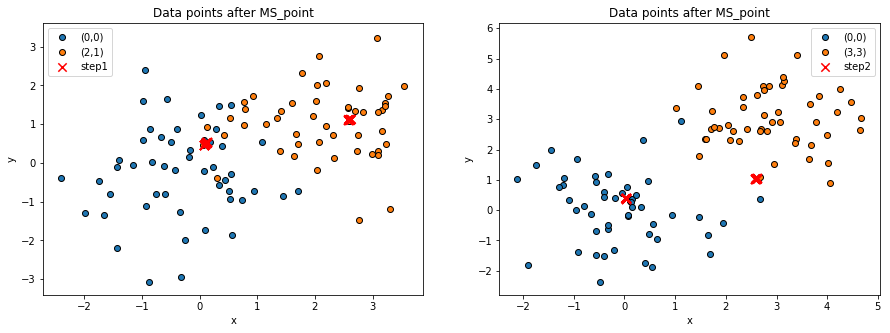

In [7]:
#Q.4.b
step1 = apply_pointwise(data1,sigma1, MS_point)
step2 = apply_pointwise(data2,sigma2, MS_point)
#visualise
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(pts0[:,0], pts0[:, 1], edgecolors = 'black', label='(0,0)')
plt.scatter(pts1[:,0], pts1[:, 1], edgecolors= 'black', label='(2,1)')
plt.scatter(step1[:, 0], step1[:, 1], marker='x',s = 70, color='red', label = 'step1')
plt.title("Data points after MS_point")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(pts00[:,0], pts00[:, 1], edgecolors = 'black', label='(0,0)')
plt.scatter(pts3[:,0], pts3[:, 1], edgecolors= 'black', label='(3,3)')
plt.scatter(step2[:, 0], step2[:, 1], marker='x',s = 70, color='red', label = 'step2')
plt.title("Data points after MS_point")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()



**5.a)** Implement the `MS` function, which implements the full mean shift algorithm by iterating `MS_point` on all the points, and merging modes so that there are no two modes at distance -- normalized by `sigma` -- smaller than 0.5, and all points are assigned to the closest mode, at a distance smaller than 0.5. <br/>
It must return a list of the modes and a label (corresponding to a mode) for each point. <br/>
**b)** Test it on your synthetic data and visualize the results for different values of `sigma`. <br/>
**c)** Comment on the result for each `data` vector and the different `sigma`.

In [8]:
#Q5.a

def MS(data, sigma):
    tolerance = 0.5
    l = apply_pointwise(data, sigma, MS_point)

    labels = np.zeros(len(l))
    acounted_for = [] #already accounted for points
    modes = [] #remaining points after filtering
    for (i1, l1) in enumerate(l):
      if i1 in acounted_for:
          continue
      acounted_for.append(i1)
      labels[i1] = len(modes) #give label
      avg = l1.copy() 
      count = 1
      # filter the neighbouring points which are smaller than tolerance
      # merge the neighbouring points by averaging them
      # and mark them as accounted_for
      for (i2, l2) in enumerate(l):
          if i1 == i2:
              continue
          if np.linalg.norm((l1 - l2)/sigma) < tolerance:
              acounted_for.append(i2)
              labels[i2] = len(modes) #same label as i1
              avg += l2.copy()
              count += 1
      modes.append(avg/count)
    return labels, np.array(modes)



Sigma =  [0.7 0.7]


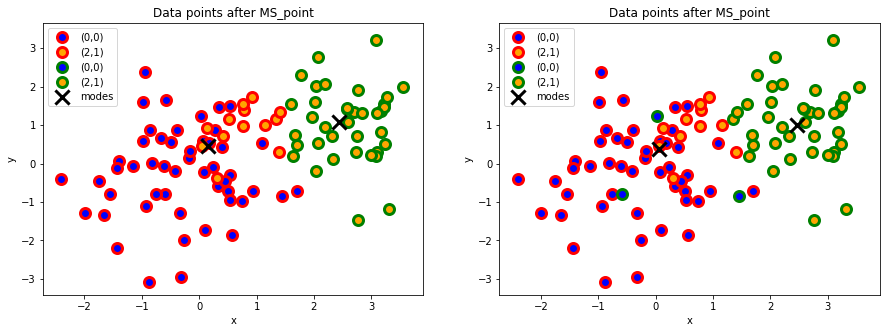

Sigma =  [0.6 0.6]


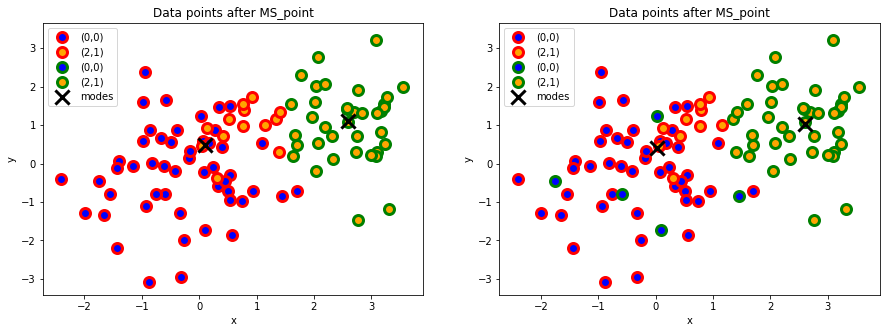

Sigma =  [0.5 0.5]


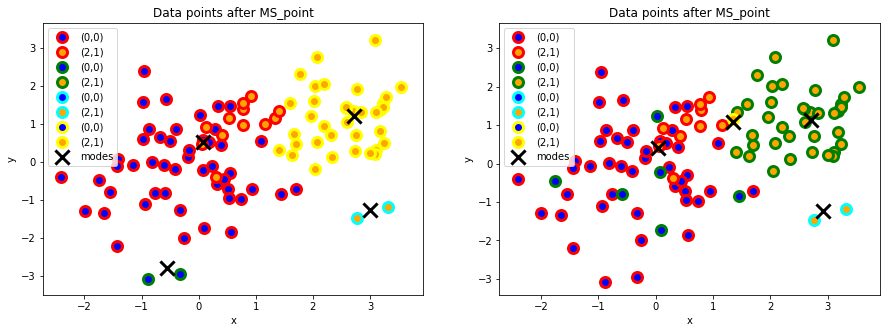

In [9]:
#Q5.b

sigmas = [np.array([0.7, 0.7]), np.array([0.6, 0.6]), np.array([0.5,0.5])]
for s in sigmas:
  labels1, modes1 = MS(data1, s)
  labels2, modes2 = MS(data2, s)

  plt.figure(figsize=(15,5))
  print('Sigma = ', s)
  plt.subplot(1,2,1)
  n = len(modes1)
  colors = ['red', 'green', 'cyan', 'yellow', 'gray']
  for cind in range(n):
    cluster = (labels1 == cind)
    plt.scatter(pts0[cluster[:50],0], pts0[cluster[:50], 1], s = 100, linewidth = 3, color = 'blue', edgecolors = colors[cind], label='(0,0)')
    plt.scatter(pts1[cluster[50:],0], pts1[cluster[50:], 1], s = 100, linewidth = 3, color = 'orange', edgecolors= colors[cind], label='(2,1)')

  plt.scatter(modes1[:,0], modes1[:,1], marker='x',s = 200, color='black',linewidth='3', label ='modes')
  plt.title("Data points after MS_point")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.legend()


  plt.subplot(1,2,2)
  n = len(modes2)
  colors = ['red', 'green', 'cyan', 'yellow', 'gray']
  for cind in range(n):
    cluster = (labels2 == cind)
    plt.scatter(pts0[cluster[:50],0], pts0[cluster[:50], 1], s = 100, linewidth = 3, color = 'blue', edgecolors = colors[cind], label='(0,0)')
    plt.scatter(pts1[cluster[50:],0], pts1[cluster[50:], 1], s = 100, linewidth = 3, color = 'orange', edgecolors= colors[cind], label='(2,1)')

  plt.scatter(modes2[:,0], modes2[:,1], marker='x',s = 200, color='black',linewidth='3', label ='modes')
  plt.title("Data points after MS_point")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.legend()
  plt.show()


**Answer 5.c**

We can observe that variance $[0,6, 0.6]$ is the best one that classifies the data into to correct clusters. When we have a lower sigma then we risk overfitting and having more clusters. Otherwise when sigma is larger than we end up classifying all the data as one big cluster.

## 2. Segmentation

**6.a)** Download [this small image](http://imagine.enpc.fr/~aubrym/lectures/introvis17/legumes_small.jpg), load it and convert it to the Lab colorspace. <br/>
**b)** Why is it necessary to change colorspace? What are the ranges of the colorvalues in Lab?

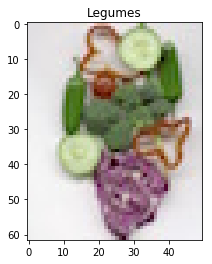

(62, 50, 3)


In [10]:
#Q.6.a
img = rgb2lab(plt.imread('legumes_small.jpg'))
plt.title('Legumes')
plt.imshow(plt.imread('legumes_small.jpg'))
plt.show()

print(img.shape)

**Answer 6.b**

Lab colorspace are used when the appereance of colors are similar. Visually in the image we can see that we have a 'cluster' of green vegetables. If we take rgb colorspace then there would be different coordinates (for different shades of green) and so it won't be considered a cluster by the algorithm. 
Hence we take the lab colorspace.

The range for Lab colorspace are:

* L from 0 to 100
* a from -127 to 128
* b from -128 to 127.

In Mean Shift segmentation, all pixels in the image will be treated as data points including both their color and position in the image.

**7.a)** Convert the *(N, M, 3)* image into an *(NM, 5)* array incuding color and position information for each point. *(Tip: use the `np.meshgrid` function)* <br/>
**b)** What would be a meaningful value for `sigma`?

In [11]:
#Q.7.a
x, y = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0]))
imgpos = np.concatenate((img, x[:,:, None], y[:,:, None]), axis=2)
data_img = np.reshape(imgpos, [-1, 5])
print(data_img.shape)

#Q.7.b
print('x in [{},{}]'.format(np.min(x), np.max(x)))
print('y in [{},{}]'.format(np.min(y), np.max(y)))

sigma_img = np.array([5,10,10,5,5])

(3100, 5)
x in [0,49]
y in [0,61]


**Answer 7.b**
A good sigma can be one that is in between the ranges for L,a,b,x,y. So I took approximately sqrt of half of those ranges

**8.a)** Use the `MS` function from the previous section to compute a meaningful segmentation of the image. <br/>
*(Tip: if your `MS` function is too slow, it might be because `MS_step` or because mode merging. Try to rewrite your answers replacing some python loops with `np.sum` and other built-in `numpy` functions that are much faster)* <br/>
**b)** Visualize the result as an image by replacing the color values of the pixels associated to each mode by the color of the mode. <br/>
**c)** Experiment with different `sigma` values and comment on the results.

c:\python37\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


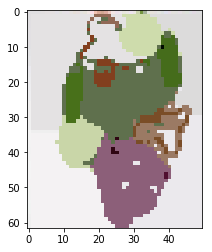

In [12]:
#Q8.a
labels_img, modes_img = MS(data_img, sigma_img)

#Q8.b
labelcolor = []
for i, lab in enumerate(labels_img):
    lab = int(lab)
    labelcolor.append(modes_img[lab][:3])

cluster_img = lab2rgb(np.array(labelcolor).reshape(img.shape))
plt.imshow(cluster_img)
plt.show()

c:\python37\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


sigma =   [100  50  50  25  25]


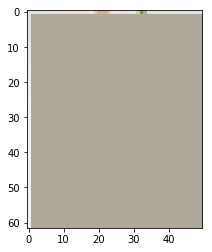

sigma =   [ 5 10 10 40  5]


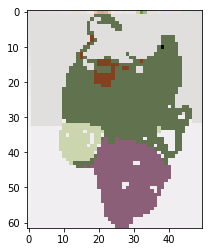

sigma =   [ 5 10 10  5 40]


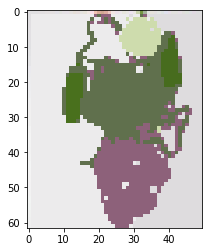

In [13]:
#Q8.c
sigmas = [np.array([100,50,50,25,25]), np.array([5,10,10,40,5]), np.array([5,10,10,5,40])]
for s in sigmas:
  labels_img, modes_img = MS(data_img, s)
  labelcolor = []
  for i, lab in enumerate(labels_img):
      lab = int(lab)
      labelcolor.append(modes_img[lab][:3])

  cluster_img = lab2rgb(np.array(labelcolor).reshape(img.shape))
  print('sigma =  ', s)
  plt.imshow(cluster_img)
  plt.show()



**Answers 8.c**

Clearly when we change the values into too large values for L,a,b then we get one cluster i.e. not correct.

In the second image we keep all the values the same but increase sigma in the x direction. We observe that the two darker-green clusters (peppers) merged with the broccoli. The peppers are directly adjacent to the broccoli in the x-direction. Hence when increasing the sigma the algorithm will underfit and consider the peppers and broccoli in 1 cluster.

But in image3 the broccoli and peppers have almost exactly the same range of y values. Hence do not participate to their clustering. So indeed we do not see any merging/difference when increasing sigma in the y-direction